# MODE

In [876]:
import tensorflow as tf
import keras as k
import numpy as np
import matplotlib.pyplot as plt

# personal modules
from py.distance_metrics import bhattacharyya
from py.eval import get_eval_datasets, replicate_model
from py.layer_selection import (Forward_Layer_Select, 
                                calculate_acc_for_labels, 
                                get_overfit_labels, 
                                get_underfit_labels,
                                get_faultiest_label)
from py.heatmap import get_heatmaps
from py.input_selection import select_next_inputs
from py.visualizations import (get_plot, 
                               visualize_array, 
                               get_samples_for_label,
                               sample_misclassifications, 
                               viz_heatmaps_for_correct_prediction, 
                               viz_heatmaps_for_false_positives, 
                               viz_heatmaps_for_false_negatives,
                               DHCI_i_k,
                               DHMI_i,
                               DHWI_i,
                               viz_most_least_similar,
                               viz_most_similar,
                               viz_least_similar)

# plot defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### References

https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers

### Parameters

In [822]:
# Underfitting Threshold
# Both the training accuracy (TrAcc)  and the testing accuracy (TeAcc)
# must be lower than this param to qualify as underfitting
theta = 0.92

# Overfitting Threshold
# The difference between the training accuracy (TrAcc) and testing accuracy (TeAcc)
# must be larger than this param to qualify as overfitting
gamma = 0.10

# Ratio between Selected Data and Random Data 
# Controls the ratio of the target class to fix and the random other classes 
# trained simultaneosly. 
# TODO: find a way to experiment with setting this automatically based on the 
# number of classes in your task. 
# TODO: see if we can use larger alpha and reduced batch sizes to control overfitting
alpha = 0.25

# Byattacharyya Distance
# If the distribution of two y_pred matrices are less than this amount, than they are
# sufficiently similar and we'll take the layer that produced the distribution first
similarity_threshold = 0.01

# Number of Epochs
# TODO: implement early stopping
epochs = 3

# Batch Size
batch_size = 2000 # they used 2000 and 4000 in the paper

### Data

In [846]:
# download MNIST
mnist = tf.keras.datasets.mnist

# split into test and train sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize to [0,1] by dividing by the max value
x_train, x_test = x_train / 255.0, x_test / 255.0

# further split x_train and y_train into new training and bug fixing sets (50/50)
from sklearn.model_selection import train_test_split
x_train, x_bug_fixes, y_train, y_bug_fixes = train_test_split(x_train, y_train, test_size=0.5, random_state=123)

print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)

print('Bug Fixing data shape: ', x_bug_fixes.shape)
print('Bug Fixing labels shape: ', y_bug_fixes.shape)

print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (30000, 28, 28)
Training labels shape:  (30000,)
Bug Fixing data shape:  (30000, 28, 28)
Bug Fixing labels shape:  (30000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


## Evaluation Model

Create a model that will be the one evaluated and retrained using MODE input selection. 

In [847]:
# create model layers
model = k.models.Sequential([
  # flatten into a single vector
  k.layers.Flatten(input_shape=(28, 28)),
  # first layer
  k.layers.Dense(28, activation=tf.nn.relu),
  #k.layers.Dropout(0.2),
  # second layer
  k.layers.Dense(28, activation=tf.nn.relu),
  #k.layers.Dropout(0.2),
  # third layer
  k.layers.Dense(28, activation=tf.nn.relu),
  #k.layers.Dropout(0.2),
  # fourth layer
  #k.layers.Dense(28, activation=tf.nn.relu),
  #k.layers.Dropout(0.2),
  # output layer
  k.layers.Dense(10, activation=tf.nn.softmax)
])

# compile with optimizer, loss, and metrics
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [848]:
# fit
model.fit(x_train, y_train, epochs=epochs)

Epoch 1/3
30000/30000 [==============================] - 38s 1ms/step - loss: 0.4645 - acc: 0.8685
Epoch 2/3
30000/30000 [==============================] - 18s 598us/step - loss: 0.2335 - acc: 0.9313
Epoch 3/3
30000/30000 [==============================] - 20s 661us/step - loss: 0.1899 - acc: 0.9443


In [849]:
# predict train (to get distributions)
y_pred_train = model.predict(x_train)

# predict test (to get distributions)
y_pred = model.predict(x_test)

In [850]:
# final train
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Train Loss: {}, Train Accuracy: {}'.format(train_loss, train_acc))

# test
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

30000/30000 [==============================] - 28s 922us/step
Train Loss: 0.16989814915557702, Train Accuracy: 0.9507
10000/10000 [==============================] - 6s 621us/step
Test Loss: 0.19690471575558186, Test Accuracy: 0.9406


## Control Model

Create a model that will be retrained on a similar amount of data but as our main model, but the data is chosen at random. 

In [851]:
control_model = replicate_model(model)

control_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# control_model.build()
# control_model.summary()

## Targeting Problematic Layers

In [801]:
use_target_layer = True

In [802]:
target_layer, cache = Forward_Layer_Select(model, 
                                           x_train, 
                                           y_train, 
                                           x_test, 
                                           y_test, 
                                           epochs, 
                                           similarity_threshold, 
                                           verbose=False)

Target Layer is the Output Layer: <keras.layers.core.Dense object at 0x000001BCAA704C88>. 
 Consider additional training because performance has not yet plateued.


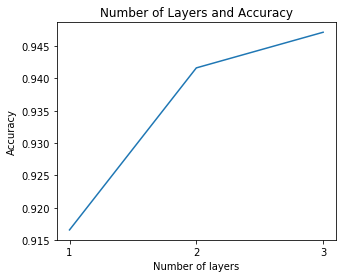

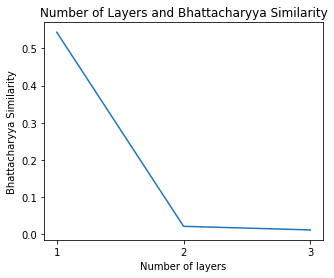

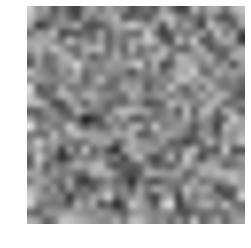

In [871]:
feature_models, accuracies, bhattacharyyas, layer_pred = cache

get_plot(accuracies, 
         title='Number of Layers and Accuracy',
         xlabel='Number of layers',
         ylabel='Accuracy')

get_plot(bhattacharyyas, 
         title='Number of Layers and Bhattacharyya Similarity',
         xlabel='Number of layers',
         ylabel='Bhattacharyya Similarity')

visualize_array(target_layer.get_weights()[0])

## Training Set Results

In [804]:
# NOTE: _o means correct and _x means incorrect and can be read as
#       "for those that were incorrectly classified"

out = get_eval_datasets(data = x_train, 
                        labels = y_train, 
                        predictions = y_pred_train)

x_train_o, y_pred_train_o, x_train_x, y_pred_train_x, y_true_train_x = out

In [805]:
accuracies_per_label_train = calculate_acc_for_labels(all_labels = y_train,
                                                      correct_labels = y_pred_train_o,
                                                      num_classes = num_classes,
                                                      labels = [])

In [806]:
accuracies_per_label_train

{0: 0.9658748745399799,
 1: 0.9839322231960269,
 2: 0.9578454332552693,
 3: 0.954411282387668,
 4: 0.9634812286689419,
 5: 0.9217359050445104,
 6: 0.9836512261580381,
 7: 0.9353091140854047,
 8: 0.9265866209262436,
 9: 0.8946830265848671}

## Test Set Results

In [807]:
# NOTE: _o means correct and _x means incorrect and can be read as
#       "for those that were incorrectly classified"

out = get_eval_datasets(data = x_test, 
                        labels = y_test, 
                        predictions = y_pred)

x_test_o, y_pred_o, x_test_x, y_pred_x, y_true_x = out

In [808]:
accuracies_per_label_test = calculate_acc_for_labels(all_labels = y_test,
                                                     correct_labels = y_pred_o,
                                                     num_classes = num_classes,
                                                     labels = [])

In [809]:
accuracies_per_label_test

{0: 0.9663265306122449,
 1: 0.9885462555066079,
 2: 0.9593023255813954,
 3: 0.9702970297029703,
 4: 0.960285132382892,
 5: 0.8901345291479821,
 6: 0.9634655532359081,
 7: 0.9123661148977604,
 8: 0.9004106776180698,
 9: 0.8820614469772051}

## Identify Problematic Labels

In [852]:
underfit_labels = get_underfit_labels(acc = accuracies_per_label_train,
                                      num_classes = num_classes,
                                      threshold = theta,
                                      labels = []) 

print(underfit_labels)

{9: 0.8946830265848671}


In [853]:
get_faultiest_label(underfit_labels)

9

In [854]:
overfit_labels = get_overfit_labels(train_acc = accuracies_per_label_train,
                                    test_acc = accuracies_per_label_test,
                                    num_classes = num_classes,
                                    threshold = gamma,
                                    labels = [])

print(overfit_labels)

No overfit labels...
{}


## Get Heatmaps

In [855]:
labels, heatmaps = get_heatmaps(correct_data = x_test_o,
                                correct_labels = y_pred_o,
                                misclassified_data = x_test_x, 
                                misclassified_labels = y_pred_x, 
                                misclassified_correct_labels = y_true_x, 
                                num_classes = num_classes,
                                labels = [], 
                                type = 'hci')

## Get Next Batch

In [ ]:
next_X, next_y, x_bug_fixes, y_bug_fixes = select_next_inputs(bug_fix_data = x_bug_fixes,
                                                              bug_fix_labels = y_bug_fixes,
                                                              heatmaps = heatmaps,
                                                              target_label = 1,
                                                              batch_size = batch_size,
                                                              ratio = alpha,
                                                              for_underfitting=True,
                                                              distance_metric='dot')
# check out an example of a desirable target
print(next_y[0])
visualize_array(next_X[0])

## Targeted Label Retraining

0. Train model on all training data and evaluate performance on test data. 


1. Starting with underfitting first, select the target layer that enters a saturation point. 
2. Use the predictions of the target layer, generate heatmaps for each label.
3. Calculate the per-label accuracy.
4. Select the most faulty label for retraining (break if none). 
5. Generate a batch tailored to improving performance on that label.
6. Train on this new batch
7. Evaluate performance
8. Return to 1 and repeat until there are no more faulty underfitting labels


9. Select the most faulty overfitting label
10. Use the predictions of the target layer, generate heatmaps for each label.
11. Calculate the per-label accuracy.
12. Select the most faulty label for retraining (break if none). 
13. Generate a batch tailored to improving performance on that label.
14. Train on this new batch
15. Evaluate performance
16. Return to 1 and repeat until there are no more faulty underfitting labels


17. Check if there are anymore underfitting labels, if so, return to 1

In [832]:
max_iter = 5

distance_metrics = ['dot', 'cosine', 'manhattan', 'euclidean', 'minkowski', 'earthmover', 'chebyshev', 'canberra', 'braycurtis']

for distance_metric in distance_metrics:
    
    print('#####################################################################')
    print('Testing: {} similarity'.format(distance_metric))
    print('#####################################################################')
    
    # download MNIST
    mnist = tf.keras.datasets.mnist

    # split into test and train sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # normalize to [0,1] by dividing by the max value
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # further split x_train and y_train into new training and bug fixing sets (50/50)
    from sklearn.model_selection import train_test_split
    x_train, x_bug_fixes, y_train, y_bug_fixes = train_test_split(x_train, y_train, test_size=0.5, random_state=123)

    print('Training data shape: ', x_train.shape)
    print('Training labels shape: ', y_train.shape)

    print('Bug Fixing data shape: ', x_bug_fixes.shape)
    print('Bug Fixing labels shape: ', y_bug_fixes.shape)

    print('Test data shape: ', x_test.shape)
    print('Test labels shape: ', y_test.shape)

    # create model layers
    model = k.models.Sequential([
      # flatten into a single vector
      k.layers.Flatten(input_shape=(28, 28)),
      # first layer
      k.layers.Dense(28, activation=tf.nn.relu),
      #k.layers.Dropout(0.2),
      # second layer
      k.layers.Dense(28, activation=tf.nn.relu),
      #k.layers.Dropout(0.2),
      # third layer
      #k.layers.Dense(28, activation=tf.nn.relu),
      #k.layers.Dropout(0.2),
      # fourth layer
      #k.layers.Dense(28, activation=tf.nn.relu),
      #k.layers.Dropout(0.2),
      # output layer
      k.layers.Dense(10, activation=tf.nn.softmax)
    ])

    # compile with optimizer, loss, and metrics
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # fit
    model.fit(x_train, y_train, epochs=epochs)

    # predict test (to get distributions)
    y_pred = model.predict(x_test)

    # test
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print('Initial Test Loss: {}, Initial Test Accuracy: {}'.format(test_loss, test_acc))

    control_model = replicate_model(model)

    control_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

    i = 0
    while i < max_iter:

        # control model with no specialized batch selection
        control_batch_x, control_batch_y = x_bug_fixes[:batch_size], y_bug_fixes[:batch_size]
        control_model.fit(control_batch_x, control_batch_y, epochs=epochs, verbose=0)

        # identify target layer
        print('Identifying target layer...')
        target_layer, cache = Forward_Layer_Select(model, 
                                                   x_train, 
                                                   y_train, 
                                                   x_test, 
                                                   y_test, 
                                                   epochs, 
                                                   similarity_threshold, 
                                                   verbose=False)

        feature_models, accuracies, bhattacharyyas, layer_pred = cache

        # breakout eval sets
        out = get_eval_datasets(data = x_test, 
                                labels = y_test, 
                                predictions = layer_pred)

        data_correct, labels_correct, data_incorrect, labels_incorrect, labels_corrected = out

        # generate heatmaps
        labels, heatmaps = get_heatmaps(correct_data = data_correct,
                                        correct_labels = labels_correct,
                                        misclassified_data = data_incorrect, 
                                        misclassified_labels = labels_incorrect, 
                                        misclassified_correct_labels = labels_corrected, 
                                        num_classes = num_classes,
                                        labels = [], 
                                        type = 'hci')

        # identify buggy labels
        accuracies_per_label_target = calculate_acc_for_labels(all_labels = y_test,
                                                               correct_labels = labels_correct,
                                                               num_classes = num_classes,
                                                               labels = [])

        underfit_labels = get_underfit_labels(acc = accuracies_per_label_target,
                                              num_classes = num_classes,
                                              threshold = theta,
                                              labels = []) 


        # select the most faulty underfitting label
        if len(underfit_labels) > 0:
            faultiest_label = get_faultiest_label(underfit_labels)
            print('Creating a batch for faultiest label: {}. There are {} faulty labels in total...'.format(faultiest_label, 
                                                                                                           len(underfit_labels)))
            print('Faulty labels: ', underfit_labels)
        else:
            print('MODE retraining complete!')
            break

        # generate a batch tailored to improving performance on that label
        next_X, next_y, x_bug_fixes, y_bug_fixes = select_next_inputs(bug_fix_data = x_bug_fixes,
                                                                      bug_fix_labels = y_bug_fixes,
                                                                      heatmaps = heatmaps,
                                                                      target_label = faultiest_label,
                                                                      batch_size = batch_size,
                                                                      ratio = alpha,
                                                                      for_underfitting = True,
                                                                      distance_metric = distance_metric)

        # train on this new batch
        model.fit(next_X, next_y, epochs=epochs, verbose=1)

        # evaluate performance
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

        # repeat until there are no more faulty underfitting labels
        i += 1

        print('{} iterations left...\n'.format(max_iter - i))

    print('Control model performance to beat:')  
    control_loss, control_acc = control_model.evaluate(x_test, y_test, verbose=0)
    print('Control Test Loss: {}, Control Test Accuracy: {}'.format(control_loss, control_acc))

#####################################################################
Testing: dot similarity
#####################################################################
Training data shape:  (30000, 28, 28)
Training labels shape:  (30000,)
Bug Fixing data shape:  (30000, 28, 28)
Bug Fixing labels shape:  (30000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)
Initial Test Loss: 2.305873849105835, Initial Test Accuracy: 0.0811


Exception ignored in: <bound method ScopedTFStatus.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFStatus object at 0x000001F452B229E8>>
Traceback (most recent call last):
  File "c:\users\fabrice\appdata\local\continuum\anaconda3\envs\cs239_project\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 39, in __del__
    c_api.TF_DeleteStatus(self.status)
AttributeError: 'ScopedTFStatus' object has no attribute 'status'


Epoch 1/3
30000/30000 [==============================] - 24s 814us/step - loss: 0.4807 - acc: 0.8605
Epoch 2/3
30000/30000 [==============================] - 12s 392us/step - loss: 0.2393 - acc: 0.9300
Epoch 3/3
30000/30000 [==============================] - 12s 398us/step
Train Loss: 0.15791396210491657, Train Accuracy: 0.9531333333333334
10000/10000 [==============================] - 4s 383us/step
Test Loss: 0.19272049658969045, Test Accuracy: 0.9412
Identifying target layer...
Target Layer is the Output Layer: <keras.layers.core.Dense object at 0x000001BCA42CA908>. 
 Consider additional training because performance has not yet plateued.
Creating a batch for faultiest label: 9. There are 2 faulty labels in total...
Faulty labels:  {5: 0.9080717488789237, 9: 0.9028741328047571}
Bug Fixing Pool - # of samples remaining: 28000
Epoch 1/3
2000/2000 [==============================] - 1s 392us/step - loss: 0.1544 - acc: 0.9505
Epoch 2/3
2000/2000 [==============================] - 1s 407us/

2000/2000 [==============================] - 1s 411us/step - loss: 0.0867 - acc: 0.9730
Test Loss: 0.17993740803487598, Test Accuracy: 0.9451
1 iterations left...

Identifying target layer...
Target Layer is the Output Layer: <keras.layers.core.Dense object at 0x000001BCA2C8AE10>. 
 Consider additional training because performance has not yet plateued.
Creating a batch for faultiest label: 8. There are 1 faulty labels in total...
Faulty labels:  {8: 0.917864476386037}
Bug Fixing Pool - # of samples remaining: 20000
Epoch 1/3
2000/2000 [==============================] - 1s 458us/step - loss: 0.1452 - acc: 0.9605
Epoch 2/3
2000/2000 [==============================] - 1s 472us/step - loss: 0.0968 - acc: 0.9740
Epoch 3/3
2000/2000 [==============================] - 1s 446us/step - loss: 0.0771 - acc: 0.9795
Test Loss: 0.174738413560763, Test Accuracy: 0.9472
0 iterations left...

Control model performance to beat:
Control Test Loss: 0.17687192430403084, Control Test Accuracy: 0.9464
######

2000/2000 [==============================] - 1s 462us/step - loss: 0.1605 - acc: 0.9550 0s - loss: 0.1780 - acc: 
Epoch 2/3
2000/2000 [==============================] - 1s 421us/step - loss: 0.1009 - acc: 0.9725
Epoch 3/3
2000/2000 [==============================] - 1s 442us/step - loss: 0.0765 - acc: 0.9800
Test Loss: 0.21238807359859346, Test Accuracy: 0.9369
1 iterations left...

Identifying target layer...
Target Layer is the Output Layer: <keras.layers.core.Dense object at 0x000001F455DBAEB8>. 
 Consider additional training because performance has not yet plateued.
Creating a batch for faultiest label: 5. There are 1 faulty labels in total...
Faulty labels:  {5: 0.9103139013452914}
Bug Fixing Pool - # of samples remaining: 20000
Epoch 1/3
2000/2000 [==============================] - 1s 428us/step - loss: 0.2403 - acc: 0.9260
Epoch 2/3
2000/2000 [==============================] - 1s 443us/step - loss: 0.1550 - acc: 0.9495
Epoch 3/3
2000/2000 [==============================] - 1s 44

Bug Fixing Pool - # of samples remaining: 26000
Epoch 1/3
2000/2000 [==============================] - 1s 497us/step - loss: 0.1937 - acc: 0.9440
Epoch 2/3
2000/2000 [==============================] - 1s 483us/step - loss: 0.1398 - acc: 0.9600
Epoch 3/3
2000/2000 [==============================] - 1s 483us/step - loss: 0.1064 - acc: 0.9725
Test Loss: 0.17916801863089205, Test Accuracy: 0.948
3 iterations left...

Identifying target layer...
Target Layer is the Output Layer: <keras.layers.core.Dense object at 0x000001F46673F358>. 
 Consider additional training because performance has not yet plateued.
Creating a batch for faultiest label: 5. There are 1 faulty labels in total...
Faulty labels:  {5: 0.9114349775784754}
Bug Fixing Pool - # of samples remaining: 24000
Epoch 1/3
2000/2000 [==============================] - 1s 482us/step - loss: 0.1854 - acc: 0.9365
Epoch 2/3
2000/2000 [==============================] - 1s 512us/step - loss: 0.1344 - acc: 0.9605
Epoch 3/3
2000/2000 [========

30000/30000 [==============================] - 12s 415us/step
Train Loss: 0.16840694125294686, Train Accuracy: 0.9511666666666667
10000/10000 [==============================] - 4s 415us/step
Test Loss: 0.19239651921093465, Test Accuracy: 0.9416
Identifying target layer...
Target Layer is the Output Layer: <keras.layers.core.Dense object at 0x000001F49A90A470>. 
 Consider additional training because performance has not yet plateued.
Creating a batch for faultiest label: 5. There are 2 faulty labels in total...
Faulty labels:  {5: 0.897982062780269, 8: 0.9096509240246407}
Bug Fixing Pool - # of samples remaining: 28000
Epoch 1/3
2000/2000 [==============================] - 1s 527us/step - loss: 0.1574 - acc: 0.9560
Epoch 2/3
2000/2000 [==============================] - 1s 514us/step - loss: 0.1099 - acc: 0.9700
Epoch 3/3
2000/2000 [==============================] - 1s 505us/step - loss: 0.0892 - acc: 0.9800
Test Loss: 0.20670587656125428, Test Accuracy: 0.9372
4 iterations left...

Ident

Target Layer is the Output Layer: <keras.layers.core.Dense object at 0x000001F4D5268358>. 
 Consider additional training because performance has not yet plateued.
No underfit labels...
MODE retraining complete!
Control model performance to beat:
Control Test Loss: 0.16639149446375667, Control Test Accuracy: 0.9508


In [834]:
max_iter = 5

distance_metrics = ['dot', 'cosine', 'manhattan', 'euclidean', 'minkowski', 'earthmover', 'chebyshev', 'canberra', 'braycurtis']

for distance_metric in distance_metrics:
    
    print('#####################################################################')
    print('Testing: {} similarity'.format(distance_metric))
    print('#####################################################################')
    
    # download MNIST
    mnist = tf.keras.datasets.mnist

    # split into test and train sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # normalize to [0,1] by dividing by the max value
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # further split x_train and y_train into new training and bug fixing sets (50/50)
    from sklearn.model_selection import train_test_split
    x_train, x_bug_fixes, y_train, y_bug_fixes = train_test_split(x_train, y_train, test_size=0.5, random_state=123)

    print('Training data shape: ', x_train.shape)
    print('Training labels shape: ', y_train.shape)

    print('Bug Fixing data shape: ', x_bug_fixes.shape)
    print('Bug Fixing labels shape: ', y_bug_fixes.shape)

    print('Test data shape: ', x_test.shape)
    print('Test labels shape: ', y_test.shape)

    # create model layers
    model = k.models.Sequential([
      # flatten into a single vector
      k.layers.Flatten(input_shape=(28, 28)),
      # first layer
      k.layers.Dense(28, activation=tf.nn.relu),
      #k.layers.Dropout(0.2),
      # second layer
      k.layers.Dense(28, activation=tf.nn.relu),
      #k.layers.Dropout(0.2),
      # third layer
      #k.layers.Dense(28, activation=tf.nn.relu),
      #k.layers.Dropout(0.2),
      # fourth layer
      #k.layers.Dense(28, activation=tf.nn.relu),
      #k.layers.Dropout(0.2),
      # output layer
      k.layers.Dense(10, activation=tf.nn.softmax)
    ])

    # compile with optimizer, loss, and metrics
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # fit
    model.fit(x_train, y_train, epochs=epochs)

    # predict test (to get distributions)
    y_pred = model.predict(x_test)

    # test
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print('Initial Test Loss: {}, Initial Test Accuracy: {}'.format(test_loss, test_acc))

    control_model = replicate_model(model)

    control_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])


    i = 0
    while i < max_iter:

        # control model with no specialized batch selection
        control_batch_x, control_batch_y = x_bug_fixes[:batch_size], y_bug_fixes[:batch_size]
        control_model.fit(control_batch_x, control_batch_y, epochs=epochs, verbose=0)

        # breakout eval sets
        out = get_eval_datasets(data = x_test, 
                                labels = y_test, 
                                predictions = y_pred)

        data_correct, labels_correct, data_incorrect, labels_incorrect, labels_corrected = out

        # generate heatmaps
        labels, heatmaps = get_heatmaps(correct_data = data_correct,
                                        correct_labels = labels_correct,
                                        misclassified_data = data_incorrect, 
                                        misclassified_labels = labels_incorrect, 
                                        misclassified_correct_labels = labels_corrected, 
                                        num_classes = num_classes,
                                        labels = [], 
                                        type = 'hci')

        # identify buggy labels
        accuracies_per_label_target = calculate_acc_for_labels(all_labels = y_test,
                                                               correct_labels = labels_correct,
                                                               num_classes = num_classes,
                                                               labels = [])

        underfit_labels = get_underfit_labels(acc = accuracies_per_label_target,
                                              num_classes = num_classes,
                                              threshold = theta,
                                              labels = []) 


        # select the most faulty underfitting label
        if len(underfit_labels) > 0:
            faultiest_label = get_faultiest_label(underfit_labels)
            print('Creating a batch for faultiest label: {}. There are {} faulty labels in total...'.format(faultiest_label, 
                                                                                                           len(underfit_labels)))
            print('Faulty labels: ', underfit_labels)
        else:
            print('MODE retraining complete!')
            break

        # generate a batch tailored to improving performance on that label
        next_X, next_y, x_bug_fixes, y_bug_fixes = select_next_inputs(bug_fix_data = x_bug_fixes,
                                                                      bug_fix_labels = y_bug_fixes,
                                                                      heatmaps = heatmaps,
                                                                      target_label = faultiest_label,
                                                                      batch_size = batch_size,
                                                                      ratio = alpha,
                                                                      for_underfitting=True,
                                                                      distance_metric=distance_metric)

        # train on this new batch
        model.fit(next_X, next_y, epochs=epochs, verbose=1)

        # make predictions
        y_pred = model.predict(x_test)

        # evaluate performance
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

        # repeat until there are no more faulty underfitting labels
        i += 1

        print('{} iterations left...\n'.format(max_iter - i))

    print('Control model performance to beat:')  
    control_loss, control_acc = control_model.evaluate(x_test, y_test, verbose=0)
    print('Control Test Loss: {}, Control Test Accuracy: {}'.format(control_loss, control_acc))

#####################################################################
Testing: dot similarity
#####################################################################
Training data shape:  (30000, 28, 28)
Training labels shape:  (30000,)
Bug Fixing data shape:  (30000, 28, 28)
Bug Fixing labels shape:  (30000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)
Epoch 1/3
30000/30000 [==============================] - 38s 1ms/step - loss: 0.4783 - acc: 0.8616
Epoch 2/3
30000/30000 [==============================] - 21s 686us/step - loss: 0.2337 - acc: 0.9309
Epoch 3/3
30000/30000 [==============================] - 21s 688us/step - loss: 0.1825 - acc: 0.9475
Initial Test Loss: 0.18358689165562392, Initial Test Accuracy: 0.9436
Creating a batch for faultiest label: 5. There are 2 faulty labels in total...
Faulty labels:  {4: 0.9164969450101833, 5: 0.8845291479820628}
Bug Fixing Pool - # of samples remaining: 28000
Epoch 1/3
2000/2000 [==============================] - 1s 696us/st

Bug Fixing Pool - # of samples remaining: 28000
Epoch 1/3
2000/2000 [==============================] - 1s 663us/step - loss: 0.1514 - acc: 0.9565
Epoch 2/3
2000/2000 [==============================] - 1s 650us/step - loss: 0.1106 - acc: 0.9720
Epoch 3/3
2000/2000 [==============================] - 1s 663us/step - loss: 0.0869 - acc: 0.9785
Test Loss: 0.18789407635107636, Test Accuracy: 0.9435
4 iterations left...

Creating a batch for faultiest label: 5. There are 3 faulty labels in total...
Faulty labels:  {5: 0.8934977578475336, 8: 0.9014373716632443, 9: 0.9177403369672944}
Bug Fixing Pool - # of samples remaining: 26000
Epoch 1/3
2000/2000 [==============================] - 1s 653us/step - loss: 0.1918 - acc: 0.9415
Epoch 2/3
2000/2000 [==============================] - 1s 664us/step - loss: 0.1405 - acc: 0.9585
Epoch 3/3
2000/2000 [==============================] - 1s 665us/step - loss: 0.1069 - acc: 0.9675
Test Loss: 0.19945436557084323, Test Accuracy: 0.943
3 iterations left...



2000/2000 [==============================] - 1s 634us/step - loss: 0.1651 - acc: 0.9530
Epoch 2/3
2000/2000 [==============================] - 1s 624us/step - loss: 0.1254 - acc: 0.9640
Epoch 3/3
2000/2000 [==============================] - 1s 645us/step - loss: 0.0997 - acc: 0.9700
Test Loss: 0.20157405393123626, Test Accuracy: 0.9413
3 iterations left...

Creating a batch for faultiest label: 7. There are 2 faulty labels in total...
Faulty labels:  {5: 0.9181614349775785, 7: 0.8743914313534566}
Defaut minkowski_power = 3 set...
Bug Fixing Pool - # of samples remaining: 24000
Epoch 1/3
2000/2000 [==============================] - 1s 669us/step - loss: 0.1414 - acc: 0.9595
Epoch 2/3
2000/2000 [==============================] - 1s 649us/step - loss: 0.1031 - acc: 0.9725
Epoch 3/3
2000/2000 [==============================] - 1s 666us/step - loss: 0.0797 - acc: 0.9815
Test Loss: 0.20863893828839064, Test Accuracy: 0.9383
2 iterations left...

Creating a batch for faultiest label: 8. There

2000/2000 [==============================] - 1s 683us/step - loss: 0.2086 - acc: 0.9415
Epoch 2/3
2000/2000 [==============================] - 1s 628us/step - loss: 0.1330 - acc: 0.9615
Epoch 3/3
2000/2000 [==============================] - 1s 679us/step - loss: 0.1058 - acc: 0.9740
Test Loss: 0.18854192769899963, Test Accuracy: 0.9426
0 iterations left...

Control model performance to beat:
Control Test Loss: 0.19168198691904545, Control Test Accuracy: 0.9439
#####################################################################
Testing: canberra similarity
#####################################################################
Training data shape:  (30000, 28, 28)
Training labels shape:  (30000,)
Bug Fixing data shape:  (30000, 28, 28)
Bug Fixing labels shape:  (30000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)
Epoch 1/3
30000/30000 [==============================] - 41s 1ms/step - loss: 0.4784 - acc: 0.8630
Epoch 2/3
30000/30000 [==============================] - 2

In [867]:
import time

max_iter = 5

# download MNIST
mnist = tf.keras.datasets.mnist

# split into test and train sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize to [0,1] by dividing by the max value
x_train, x_test = x_train / 255.0, x_test / 255.0

# further split x_train and y_train into new training and bug fixing sets (50/50)
from sklearn.model_selection import train_test_split
x_train, x_bug_fixes, y_train, y_bug_fixes = train_test_split(x_train, y_train, test_size=0.5, random_state=123)

print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)

print('Bug Fixing data shape: ', x_bug_fixes.shape)
print('Bug Fixing labels shape: ', y_bug_fixes.shape)

print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

# create model layers
model = k.models.Sequential([
  # flatten into a single vector
  k.layers.Flatten(input_shape=(28, 28)),
  # first layer
  k.layers.Dense(28, activation=tf.nn.relu),
  #k.layers.Dropout(0.2),
  # second layer
  k.layers.Dense(28, activation=tf.nn.relu),
  #k.layers.Dropout(0.2),
  # third layer
  #k.layers.Dense(28, activation=tf.nn.relu),
  #k.layers.Dropout(0.2),
  # fourth layer
  #k.layers.Dense(28, activation=tf.nn.relu),
  #k.layers.Dropout(0.2),
  # output layer
  k.layers.Dense(10, activation=tf.nn.softmax)
])

# compile with optimizer, loss, and metrics
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# fit
model.fit(x_train, y_train, epochs=epochs)

# predict test (to get distributions)
y_pred = model.predict(x_test)

# test
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Initial Test Loss: {}, Initial Test Accuracy: {}'.format(test_loss, test_acc))

control_model = replicate_model(model)

control_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

start = time.time()

i = 0
while i < max_iter:

    # control model with no specialized batch selection
    control_batch_x, control_batch_y = x_bug_fixes[:batch_size], y_bug_fixes[:batch_size]
    control_model.fit(control_batch_x, control_batch_y, epochs=epochs, verbose=0)

    # identify target layer
    print('Identifying target layer...')
    target_layer, cache = Forward_Layer_Select(model, 
                                               x_train, 
                                               y_train, 
                                               x_test, 
                                               y_test, 
                                               epochs, 
                                               similarity_threshold, 
                                               verbose=False)

    feature_models, accuracies, bhattacharyyas, layer_pred = cache

    # breakout eval sets
    out = get_eval_datasets(data = x_test, 
                            labels = y_test, 
                            predictions = layer_pred)

    data_correct, labels_correct, data_incorrect, labels_incorrect, labels_corrected = out

    # generate heatmaps
    labels, heatmaps = get_heatmaps(correct_data = data_correct,
                                    correct_labels = labels_correct,
                                    misclassified_data = data_incorrect, 
                                    misclassified_labels = labels_incorrect, 
                                    misclassified_correct_labels = labels_corrected, 
                                    num_classes = num_classes,
                                    labels = [], 
                                    type = 'hci')

    # identify buggy labels
    accuracies_per_label_target = calculate_acc_for_labels(all_labels = y_test,
                                                           correct_labels = labels_correct,
                                                           num_classes = num_classes,
                                                           labels = [])

    underfit_labels = get_underfit_labels(acc = accuracies_per_label_target,
                                          num_classes = num_classes,
                                          threshold = theta,
                                          labels = []) 


    # select the most faulty underfitting label
    if len(underfit_labels) > 0:
        faultiest_label = get_faultiest_label(underfit_labels)
        print('Creating a batch for faultiest label: {}. There are {} faulty labels in total...'.format(faultiest_label, 
                                                                                                       len(underfit_labels)))
        print('Faulty labels: ', underfit_labels)
    else:
        print('MODE retraining complete!')
        break

    # generate a batch tailored to improving performance on that label
    next_X, next_y, x_bug_fixes, y_bug_fixes = select_next_inputs(bug_fix_data = x_bug_fixes,
                                                                  bug_fix_labels = y_bug_fixes,
                                                                  heatmaps = heatmaps,
                                                                  target_label = faultiest_label,
                                                                  batch_size = batch_size,
                                                                  ratio = alpha,
                                                                  for_underfitting = True,
                                                                  distance_metric = 'dot')

    # train on this new batch
    model.fit(next_X, next_y, epochs=epochs, verbose=1)

    # evaluate performance
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

    # repeat until there are no more faulty underfitting labels
    i += 1

    print('{} iterations left...\n'.format(max_iter - i))

print('Control model performance to beat:')  
control_loss, control_acc = control_model.evaluate(x_test, y_test, verbose=0)
print('Control Test Loss: {}, Control Test Accuracy: {}'.format(control_loss, control_acc))

print('That took {} seconds'.format(time.time() - start))

Training data shape:  (30000, 28, 28)
Training labels shape:  (30000,)
Bug Fixing data shape:  (30000, 28, 28)
Bug Fixing labels shape:  (30000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)
Epoch 1/3
30000/30000 [==============================] - 42s 1ms/step - loss: 0.4734 - acc: 0.8601
Epoch 2/3
30000/30000 [==============================] - 21s 690us/step - loss: 0.2168 - acc: 0.9367
Epoch 3/3
30000/30000 [==============================] - 21s 697us/step - loss: 0.1770 - acc: 0.9473
Initial Test Loss: 0.17086594227179885, Initial Test Accuracy: 0.9484
Identifying target layer...
Target Layer is the Output Layer: <keras.layers.core.Dense object at 0x000001BC7A062D30>. 
 Consider additional training because performance has not yet plateued.
Creating a batch for faultiest label: 5. There are 2 faulty labels in total...
Faulty labels:  {5: 0.9013452914798207, 8: 0.9117043121149897}
Bug Fixing Pool - # of samples remaining: 28000
Epoch 1/3
2000/2000 [==================

## Visualizations

True Label: 7 Prediction: 1


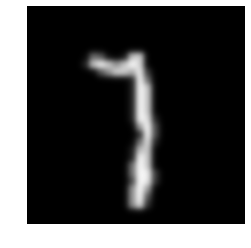

In [126]:
sample_misclassifications(misclassified_data = x_test_x, 
                          misclassified_labels = y_pred_x, 
                          misclassified_correct_labels = y_true_x, 
                          num_samples=1, 
                          shuffle=True)

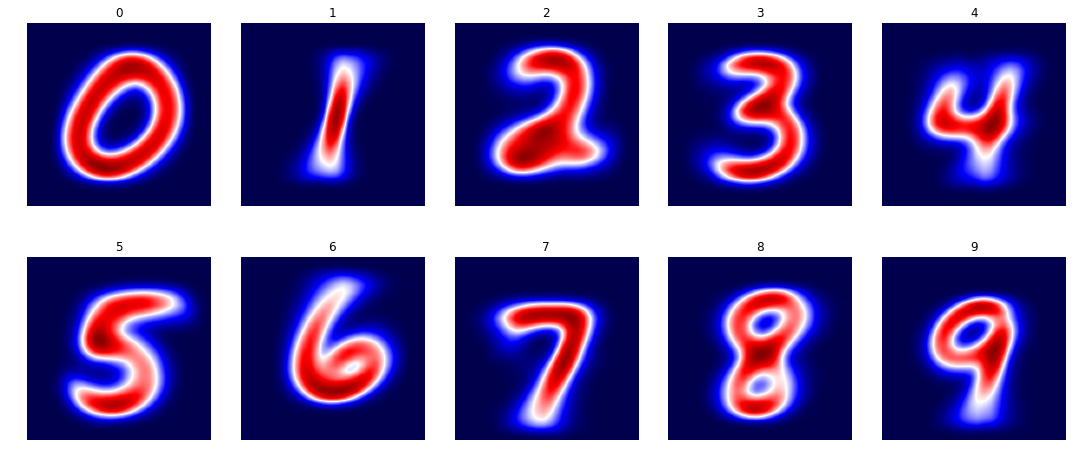

In [84]:
viz_heatmaps_for_correct_prediction(correct_data = x_test_o,
                                    correct_labels = y_pred_o,
                                    num_classes = num_classes,
                                    labels = [],
                                    cmap = 'seismic')

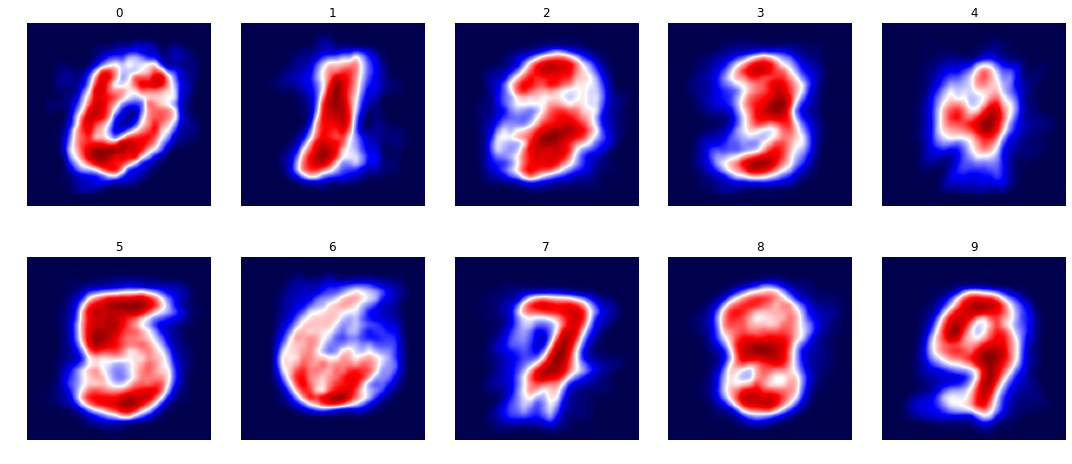

In [85]:
viz_heatmaps_for_false_positives(misclassified_data = x_test_x, 
                                 misclassified_correct_labels = y_true_x, 
                                 num_classes = num_classes,
                                 cmap='seismic')

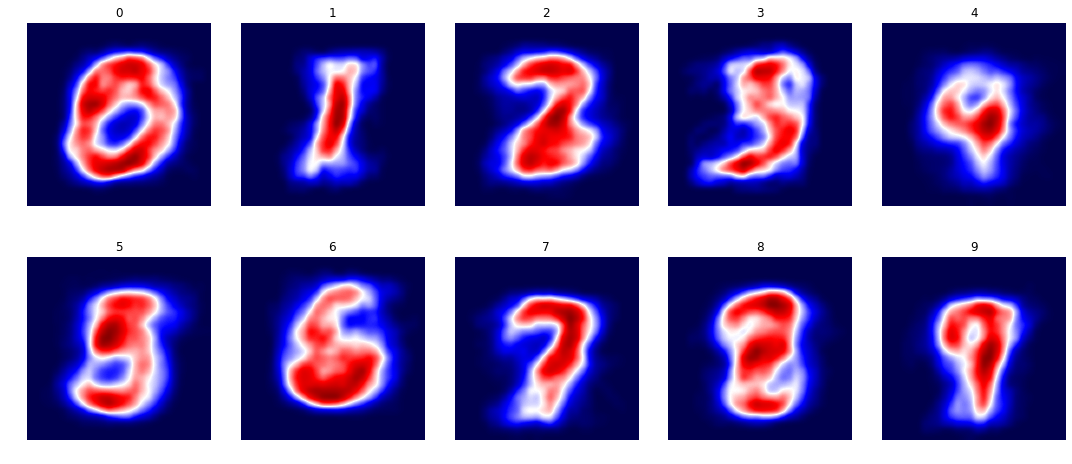

In [86]:
viz_heatmaps_for_false_negatives(misclassified_data = x_test_x, 
                                 misclassified_labels = y_pred_x, 
                                 num_classes = num_classes,
                                 cmap='seismic')

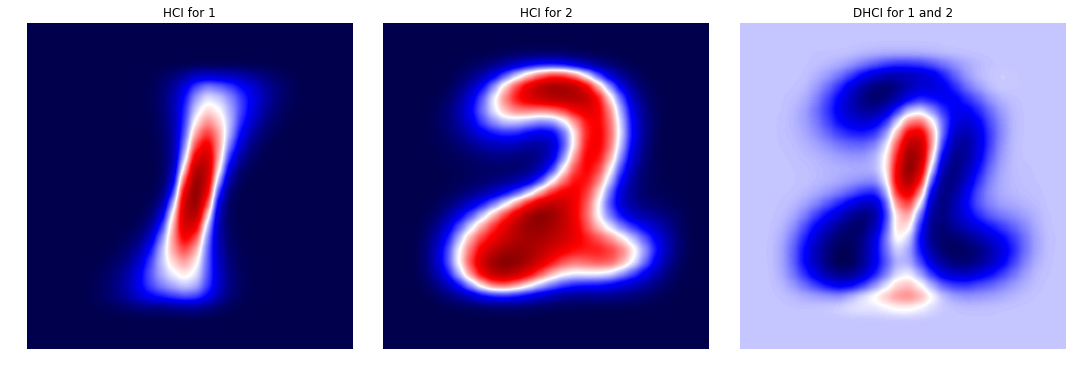

In [87]:
DHCI_i_k(correct_data = x_test_o,
         correct_labels = y_pred_o,
         first_label = 1, 
         second_label = 2,
         cmap='seismic')

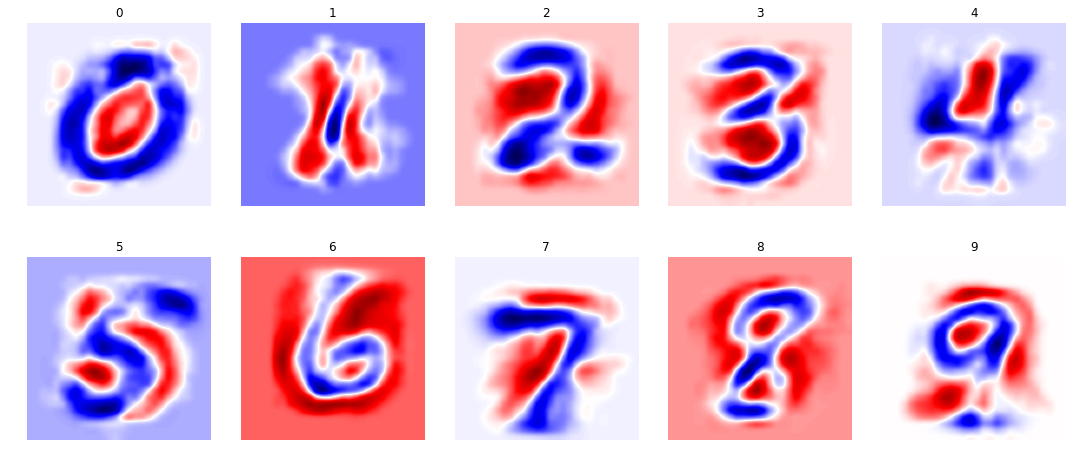

In [88]:
DHMI_i(correct_data = x_test_o,
       correct_labels = y_pred_o,
       misclassified_data = x_test_x,
       misclassified_correct_labels = y_true_x, 
       num_classes = num_classes,
       cmap='seismic')

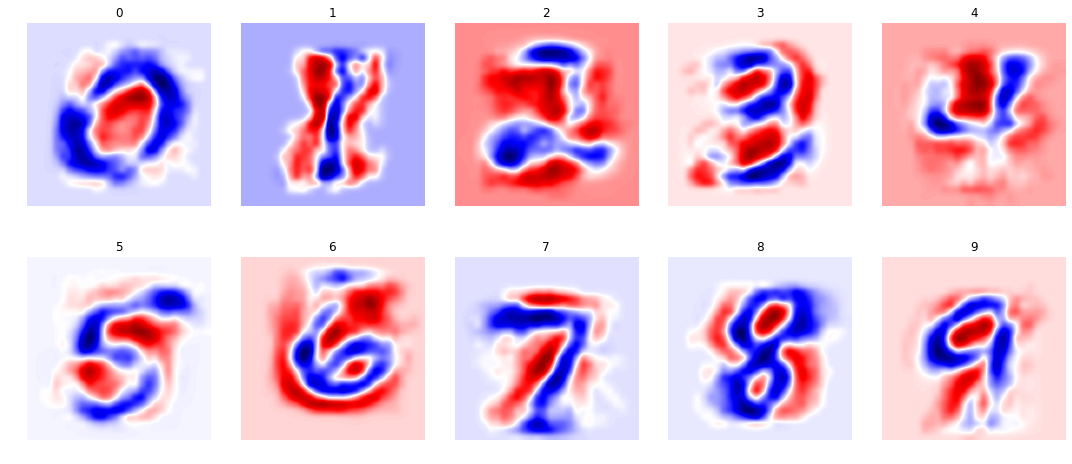

In [89]:
DHWI_i(correct_data = x_test_o,
       correct_labels = y_pred_o,
       misclassified_data = x_test_x,
       misclassified_labels = y_pred_x, 
       num_classes = num_classes,
       cmap='seismic')

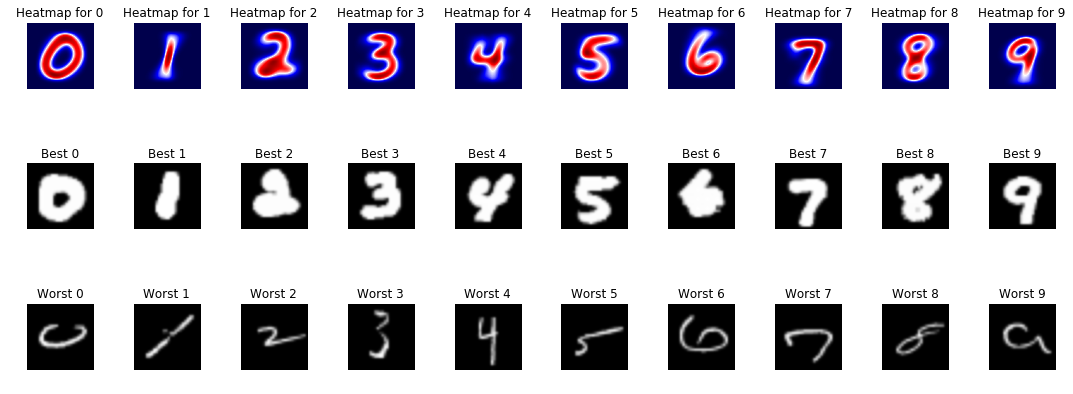

In [856]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='dot')

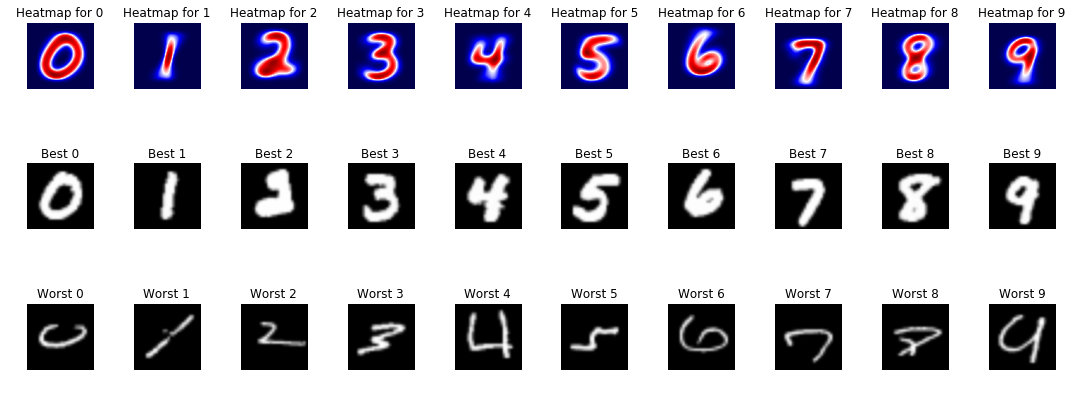

In [857]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='cosine')

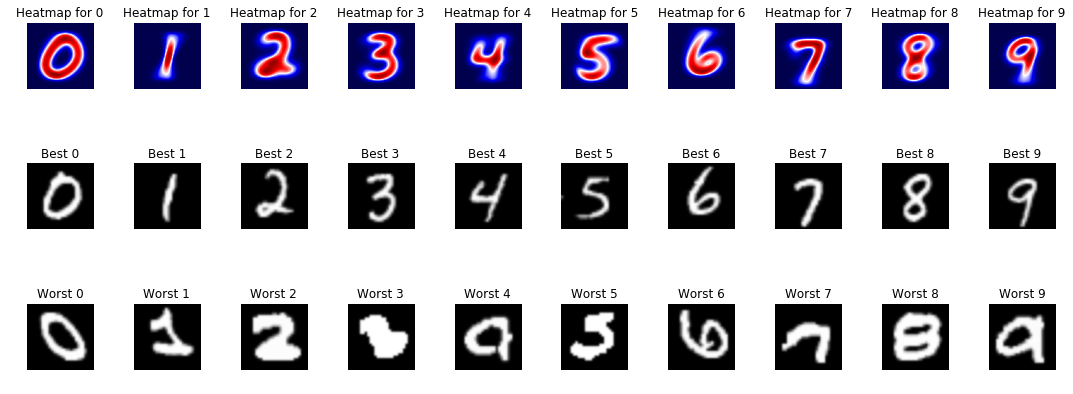

In [858]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='euclidean')

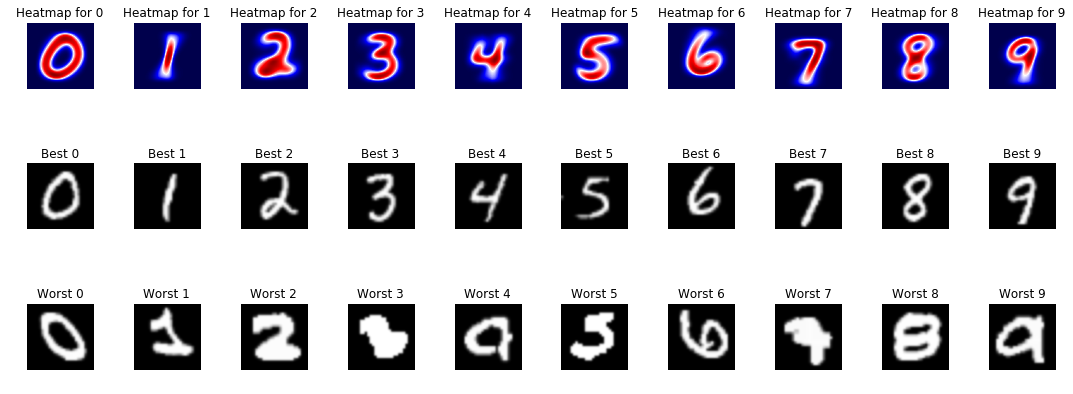

In [859]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='manhattan')

Defaut minkowski_power = 3 set...


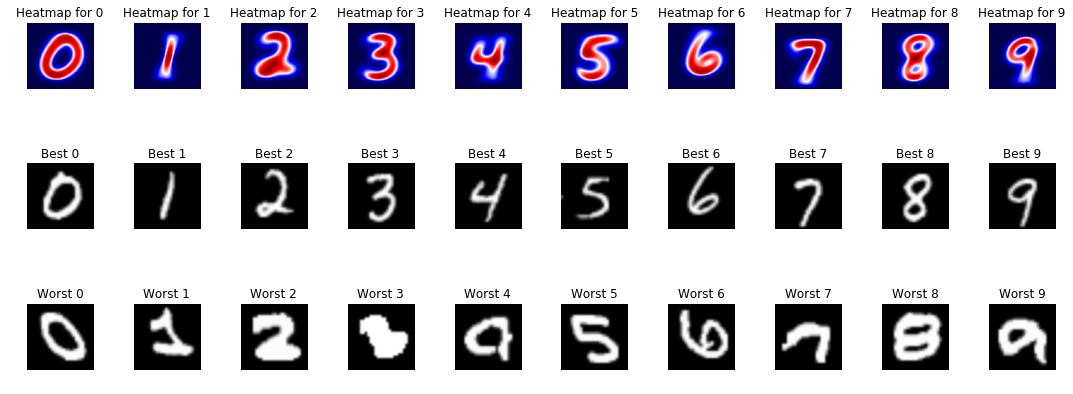

In [860]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='minkowski')

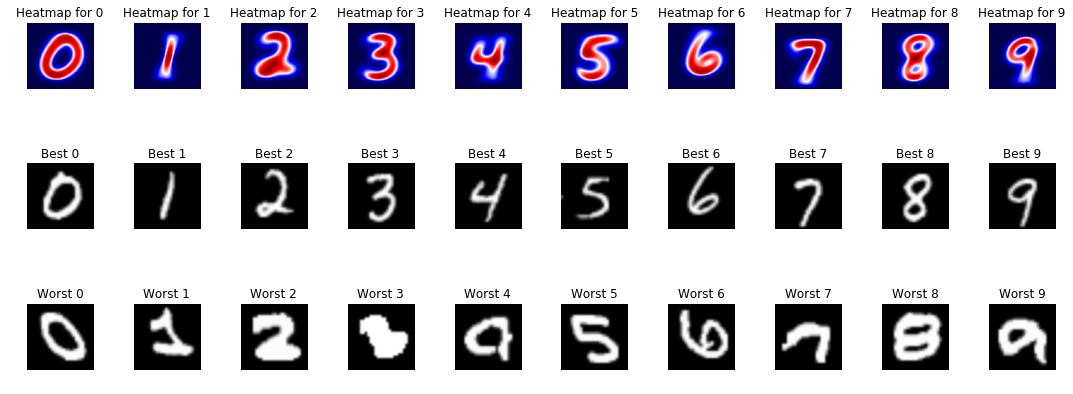

In [861]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='minkowski',
                       minkowski_power=5)

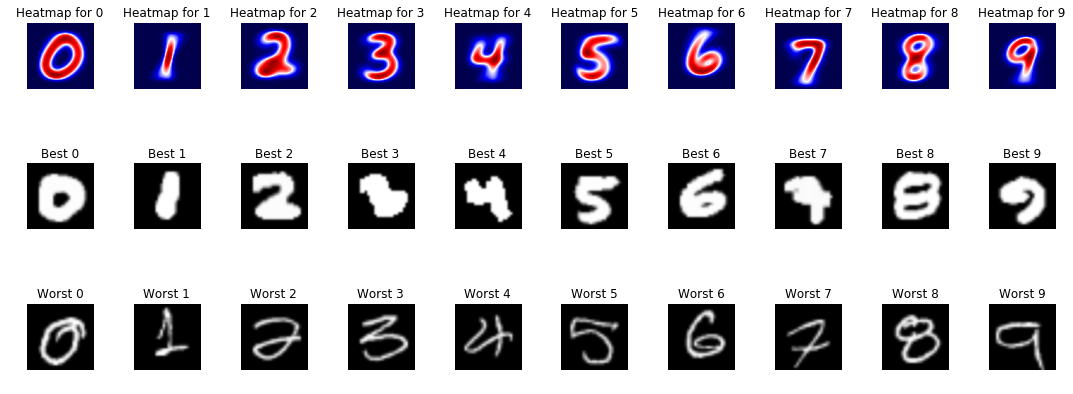

In [862]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='earthmover')

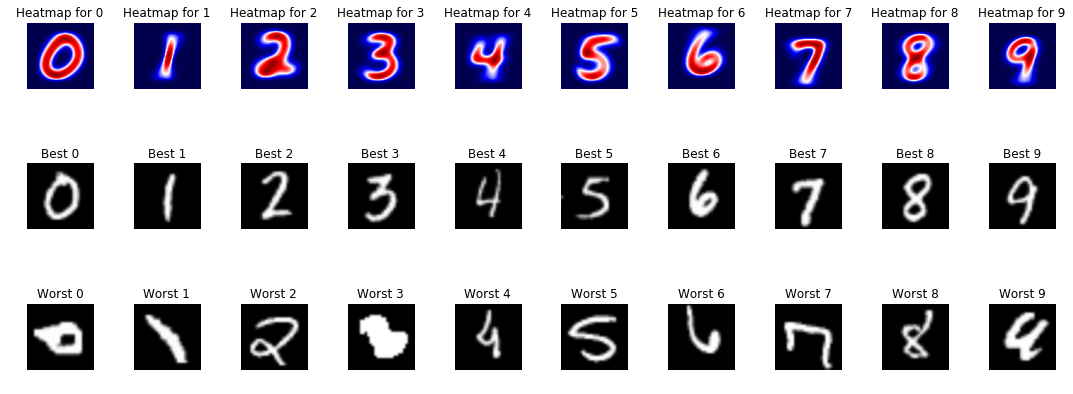

In [863]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='chebyshev')

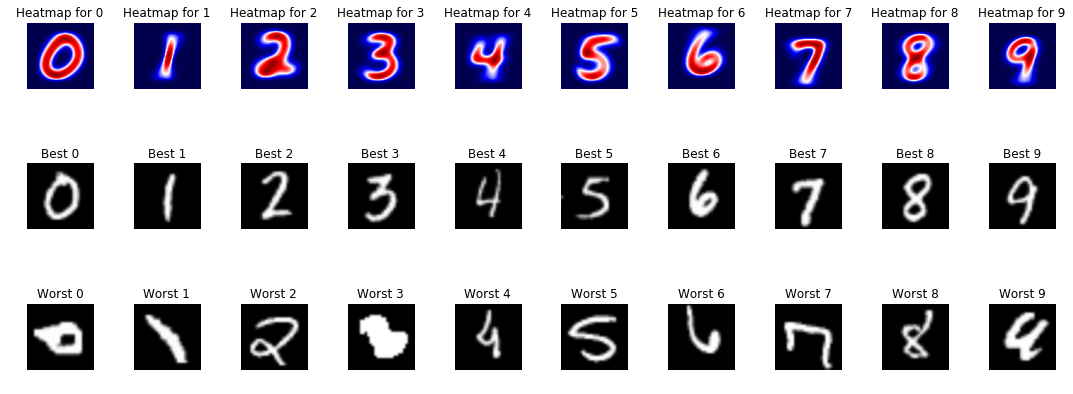

In [864]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='canberra')

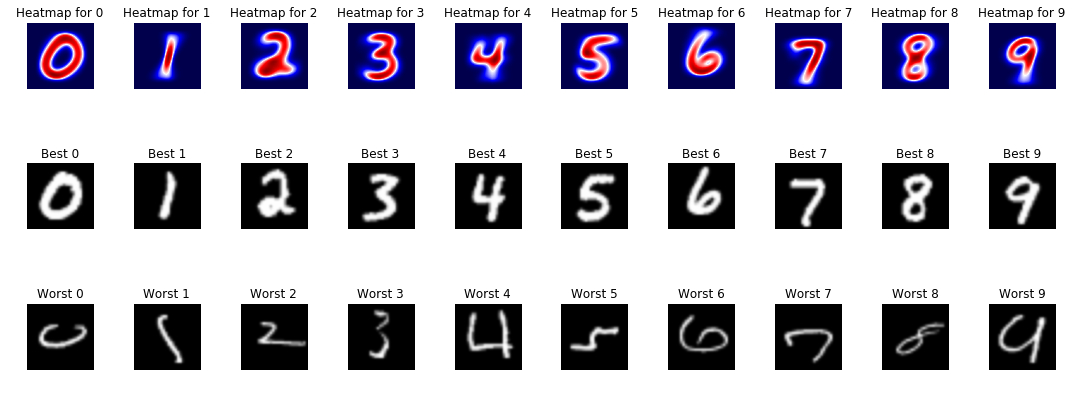

In [865]:
viz_most_least_similar(bug_fix_data = x_bug_fixes,
                       bug_fix_labels = y_bug_fixes,
                       labels = labels,
                       heatmaps = heatmaps,
                       distance_metric='braycurtis')

Defaut minkowski_power = 3 set...


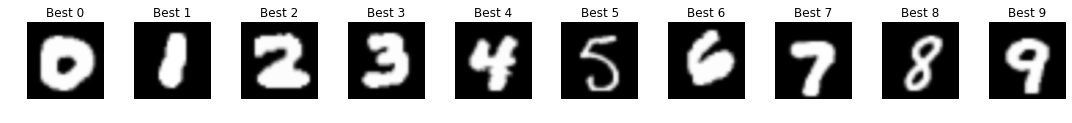

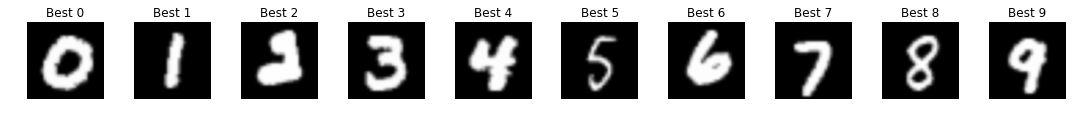

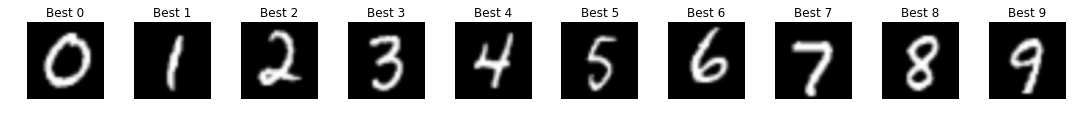

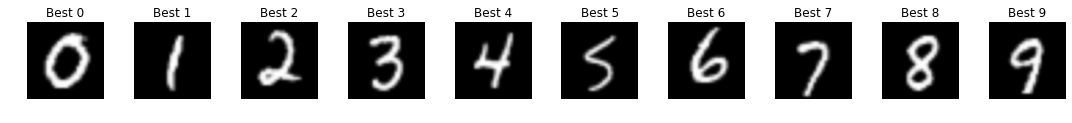

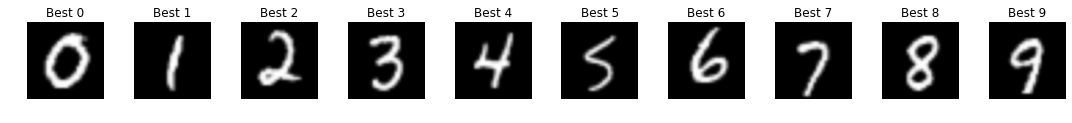

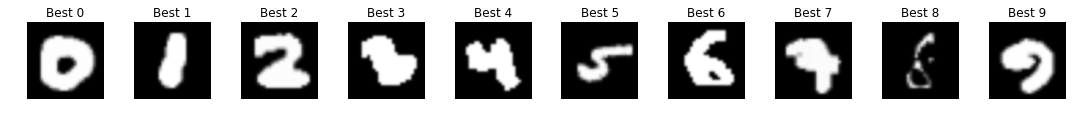

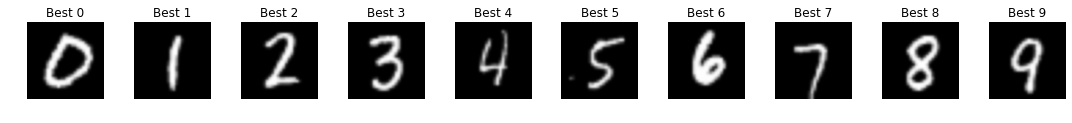

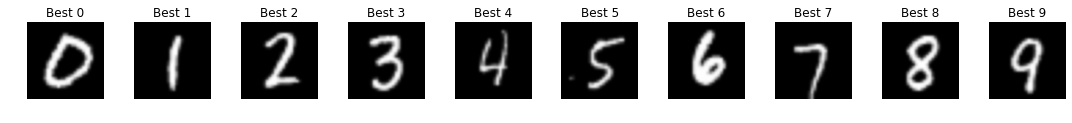

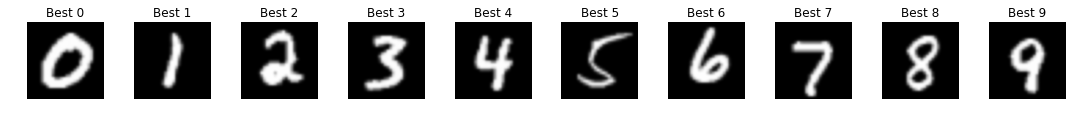

In [880]:
for distance_metric in distance_metrics:

    viz_most_similar(bug_fix_data = x_bug_fixes,
                     bug_fix_labels = y_bug_fixes,
                     labels = labels,
                     heatmaps = heatmaps,
                     distance_metric=distance_metric)

Defaut minkowski_power = 3 set...


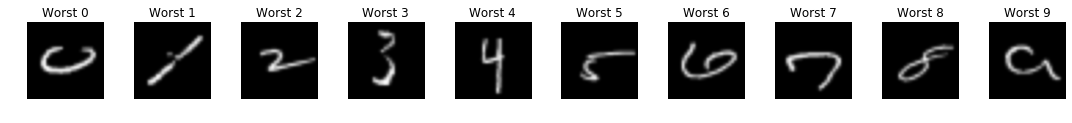

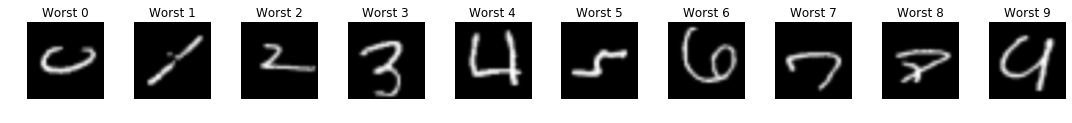

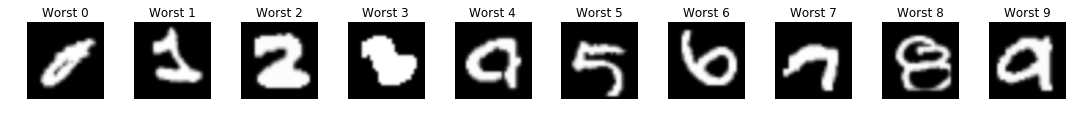

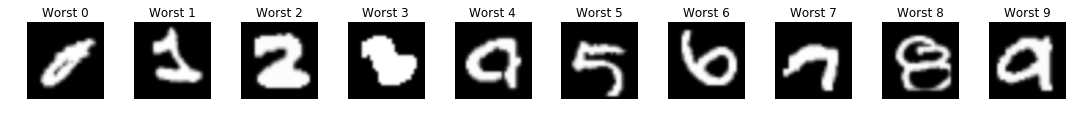

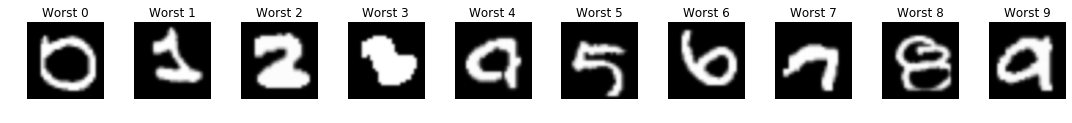

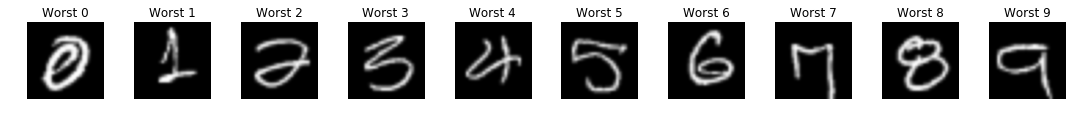

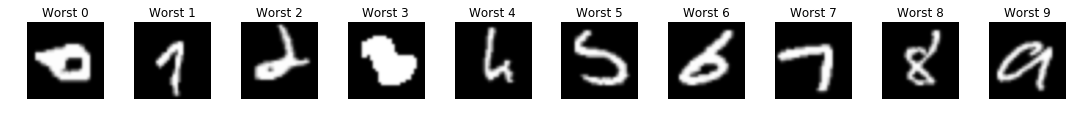

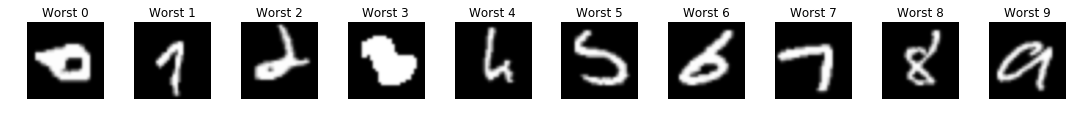

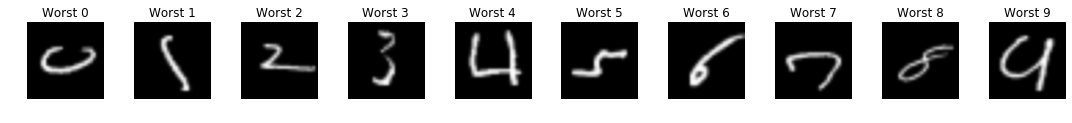

In [881]:
for distance_metric in distance_metrics:

    viz_least_similar(bug_fix_data = x_bug_fixes,
                     bug_fix_labels = y_bug_fixes,
                     labels = labels,
                     heatmaps = heatmaps,
                     distance_metric=distance_metric)